In [1]:
import pandas as pd
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
# %matplotlib inline

In [2]:
# Authenticate Spotify
client_credentials = SpotifyClientCredentials(client_id='97a92c7614f248d38952612def032c31', 
                                              client_secret='51f8eaebb63042678edbaf3d3a52f82c')
sp = spotipy.Spotify(client_credentials_manager=client_credentials)

In [3]:
# Function to get track features from Spotify
def get_track_features(track_id):
    features = sp.audio_features([track_id])[0]
    if features is not None:
        return [features['danceability'], features['energy'], features['valence']]
    return None

In [4]:
# Get track IDs for a specific mood
def get_tracks_for_mood(mood):
    results = sp.search(q=mood, type='track', limit=50)
    track_ids = [track['id'] for track in results['tracks']['items']]
    return track_ids

In [5]:
# Initialize lists to hold data
X = []
y = []

In [6]:
# Example moods to search for
moods = ['happy', 'sad', 'relaxed']

In [7]:
# Fetch features for each mood
for mood in moods:
    track_ids = get_tracks_for_mood(mood)
    for track_id in track_ids:
        features = get_track_features(track_id)
        if features:
            X.append(features)
            y.append(mood)

In [8]:
# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

In [9]:
# Convert target labels to numerical values
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [10]:
# Split the data into training, validation, and testing sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2 of total data

In [11]:
# Define the neural network
mlp = MLPClassifier(hidden_layer_sizes=(10,), max_iter=2000, random_state=42)

In [12]:
# Custom training loop to log losses
train_losses = []
val_losses = []
for epoch in range(2000):
    mlp.partial_fit(X_train, y_train, classes=np.unique(y_encoded))
    
    # Record training loss
    if epoch % 100 == 0:
        train_loss = mlp.loss_
        train_losses.append(round(train_loss, 4))  # Round the loss for readability
        
        # Validate on validation set
        val_loss = np.mean(1 - mlp.predict_proba(X_val)[np.arange(len(y_val)), y_val])
        val_losses.append(round(val_loss, 4))

        print(f"Epoch [{epoch}/2000], Train Loss: {train_loss}, Val Loss: {val_loss}")

Epoch [0/2000], Train Loss: 1.1287005411503257, Val Loss: 0.6836960874061702
Epoch [100/2000], Train Loss: 1.004662977594281, Val Loss: 0.6432738480468523
Epoch [200/2000], Train Loss: 0.9196316210680737, Val Loss: 0.6063990817737246
Epoch [300/2000], Train Loss: 0.864115906419392, Val Loss: 0.5744106569761348
Epoch [400/2000], Train Loss: 0.8257689972504868, Val Loss: 0.5457872859623154
Epoch [500/2000], Train Loss: 0.800272813292338, Val Loss: 0.522434192006868
Epoch [600/2000], Train Loss: 0.7830008888911404, Val Loss: 0.5045117353969918
Epoch [700/2000], Train Loss: 0.7709018208805041, Val Loss: 0.4899735112239877
Epoch [800/2000], Train Loss: 0.762287747871372, Val Loss: 0.4798634698350426
Epoch [900/2000], Train Loss: 0.7555793635490791, Val Loss: 0.47287198472499486
Epoch [1000/2000], Train Loss: 0.7499097941072815, Val Loss: 0.4674399907752592
Epoch [1100/2000], Train Loss: 0.744924616444696, Val Loss: 0.4635036769586746
Epoch [1200/2000], Train Loss: 0.7405029012485123, Val Lo

In [13]:
# Evaluate the model on the test set
y_pred = mlp.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.7667


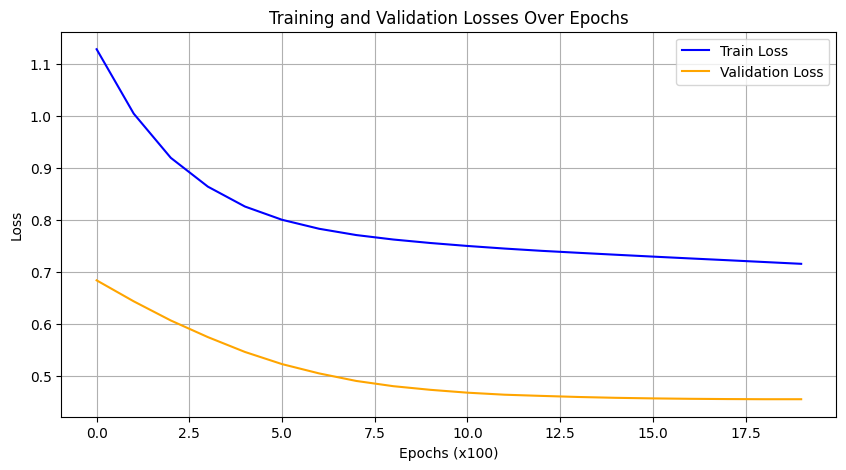

In [14]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs (x100)')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.legend()
plt.grid()
plt.show()

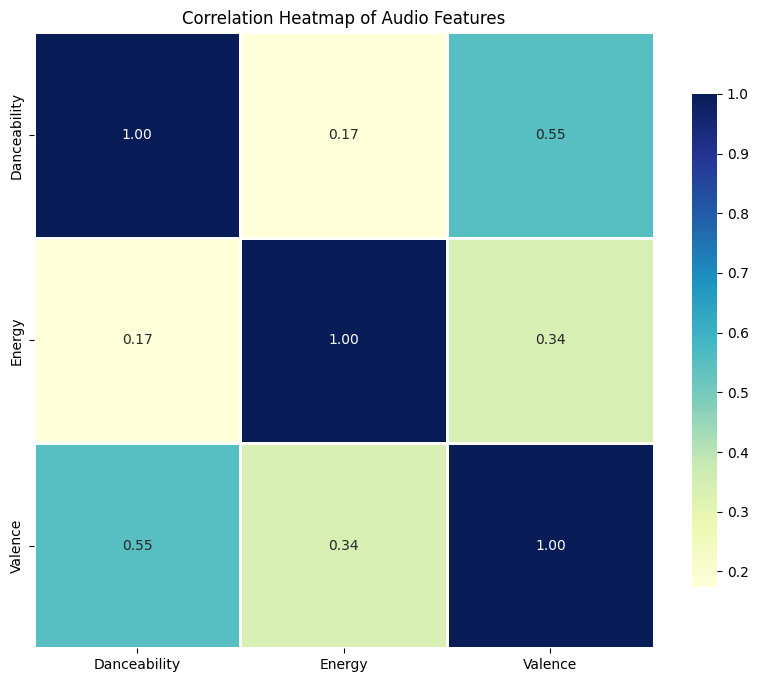

In [15]:
import seaborn as sns

# Convert features and labels to a DataFrame for easier manipulation
feature_df = pd.DataFrame(X, columns=['Danceability', 'Energy', 'Valence'])
feature_df['Mood'] = y  # Add mood labels for reference

# --- 1. Correlation Heatmap of Audio Features ---
# Calculate the correlation matrix
# Remove the 'Mood' column when calculating the correlation matrix
corr_matrix = feature_df.drop(columns=['Mood']).corr()

plt.figure(figsize=(10, 8))  # Increase the figure size
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='YlGnBu', linewidths=1, linecolor='white', cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap of Audio Features')
plt.show()

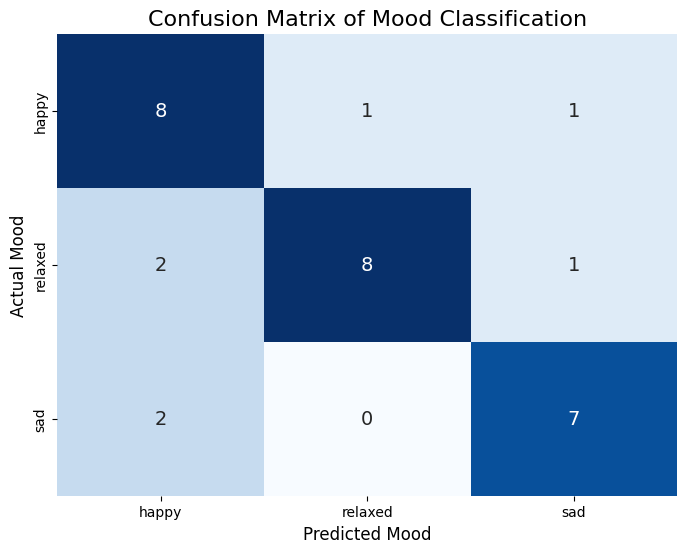

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate predictions for the test set
y_pred = mlp.predict(X_test)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Convert confusion matrix to a DataFrame for better labels
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d", cbar=False, annot_kws={"size": 14})
plt.xlabel("Predicted Mood", fontsize=12)
plt.ylabel("Actual Mood", fontsize=12)
plt.title("Confusion Matrix of Mood Classification", fontsize=16)
plt.show()


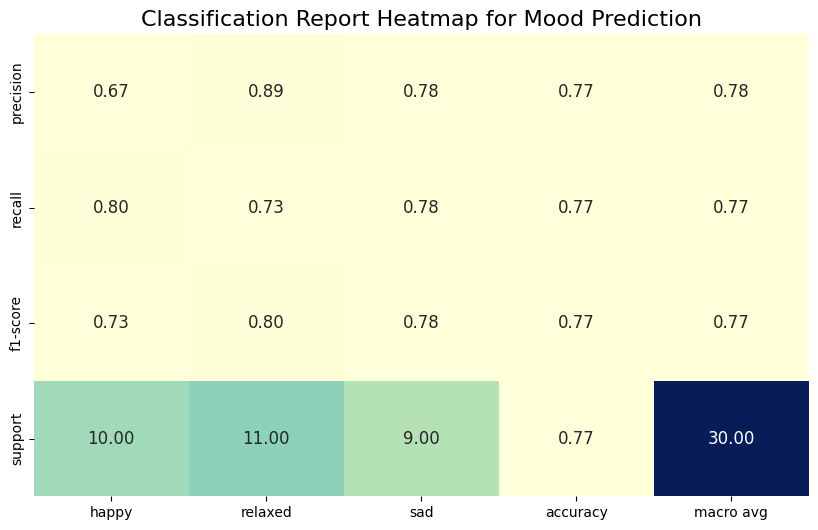

In [17]:
from sklearn.metrics import classification_report

# Generate classification report as a dictionary
report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)

# Convert report to DataFrame
report_df = pd.DataFrame(report).transpose()

# Plot the classification report as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap="YlGnBu", cbar=False, fmt=".2f", annot_kws={"size": 12})
plt.title("Classification Report Heatmap for Mood Prediction", fontsize=16)
plt.show()
